In [10]:
from dataclasses import dataclass, field
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import seaborn as sns
from typing import List
import pathlib
import sys
import os
import time

def get_working_dir():
    """Get the directory of the root of the repository.

    Returns
    -------
    str
        The absolute path to the repository root.
    """
    project_path = pathlib.Path('.').resolve()
    while not (project_path / '.git').exists():
        parent = project_path.parent
        
        if parent == project_path:
            raise RuntimeError('Could not find git root directory')
        
        project_path = parent
    
    return str(project_path)

    
def set_working_dir(project_path):
    sys.path.append(project_path)
    os.chdir(project_path)
    
set_working_dir(get_working_dir())

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import numpy as np
from ipywidgets import interact, widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

from a2020.a10.a13_singularity.code.make_movies.thylacine.reader import (
    get_variable_data,
    get_variable_data_2d,
    get_time,
    get_variable_names
)

from a2021.a09.a10_read_3d_files.code.data import all_colormaps
from a2021.a10.a14_full_2d_3d_first_plot.code.data import data_info, ALL_DATA

In [12]:

def set_plot_style():
    """Set global plotting style"""
    
    # Make images non-blurry on high pixel density screens
    %config InlineBackend.figure_format = 'svg'
    sns.set(style="ticks")

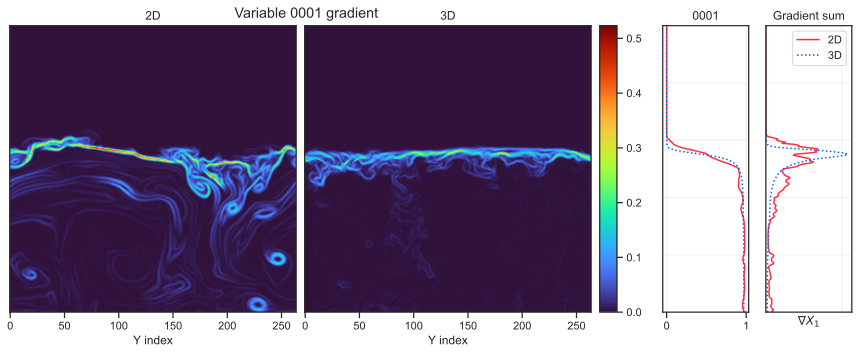

In [8]:
CUSTOM_VARIABLES = ['y_momentum', 'speed', 'abs_vely', 'abs_velx']


@dataclass
class PlotStyle:
    titles: List = field(default_factory=lambda:[])
    
    xlabels: List = field(default_factory=lambda:[])
    ylabels: List = field(default_factory=lambda:[])

    xlims: List = field(default_factory=lambda:[])
    ylims: List = field(default_factory=lambda:[])

    plot_width: float = 7
    plot_height: float = 5
    
    grid_color: str = "#aaaaaa"
    grid_alpha: float = 0.2
    
    # KDE
    # ---------
    
    kde_fill_colors: List = field(
        default_factory=lambda:
        ["#0060ff44", '#ff304144', '#8888FF44', '#BBBB1144'])

    kde_edge_colors: List = field(
        default_factory=lambda: ["#0060ff", '#ff3041', '#8888FF', '#BBBB11'])

    kde_line_width: float = 1.5    # Line width of the KDE curve
    

def bindata_path(epoch, data_dir, data_filename):
    epoch_str = f"{epoch:05d}"
    path = os.path.join(data_dir, data_filename)
    return f"{path}.{epoch_str}.bindata"


def variable_names(data_dir, data_filename, custom_variables):
    data_path = bindata_path(epoch=1, data_dir=data_dir,
                             data_filename=data_filename)
        
    data_variables = get_variable_names(data_path)
    return data_variables + custom_variables


def calc_gradients_2d(data):
    gradients = np.gradient(data)
    return np.sqrt(gradients[0]**2 + gradients[1]**2)


def calc_gradients_3d(data):
    gradients = np.gradient(data) 
    return np.sqrt(gradients[0]**2 + gradients[1]**2 + gradients[2]**2)
 
 
def calc_y_momentum(epoch, data_name, custom_variables):
    vely = load_data(epoch=epoch, variable='vely', data_name=data_name, custom_variables=custom_variables)
    density = load_data(epoch=epoch, variable='density', data_name=data_name, custom_variables=custom_variables)
    return vely * density


def calc_speed(epoch, data_name, custom_variables):
    x = load_data(epoch=epoch, variable='velx', data_name=data_name, custom_variables=custom_variables)
    y = load_data(epoch=epoch, variable='vely', data_name=data_name, custom_variables=custom_variables)
    
    if len(y.shape) == 2: # 2D
        return np.sqrt(x**2 + y**2)
    else: # 3D
        z = load_data(epoch=epoch, variable='velz', data_name=data_name, custom_variables=custom_variables)
        return np.sqrt(x**2 + y**2 + z**2)
     
 
def load_custom_data(epoch, variable, data_name, custom_variables):  
    if variable == 'y_momentum':
        return calc_y_momentum(epoch=epoch, data_name=data_name, custom_variables=custom_variables)
    
    if variable == 'speed':
        return calc_speed(epoch=epoch, data_name=data_name, custom_variables=custom_variables)
    
    if variable == 'abs_vely':
        return np.absolute(
            load_data(epoch=epoch, variable='vely', data_name=data_name, custom_variables=custom_variables)
        )
    
    if variable == 'abs_velx':
        return np.absolute(
            load_data(epoch=epoch, variable='velx',data_name=data_name, custom_variables=custom_variables)
        )
    
    raise Exception(f'Unknown custom variable {variable}') 
    
    
def load_data(epoch, variable, data_name, custom_variables):  
    if variable in custom_variables:
        return load_custom_data(epoch=epoch, variable=variable,
                                data_name=data_name, custom_variables=custom_variables)
    
    info = data_info(data_name)
      
    data_path = bindata_path(epoch=epoch,
                             data_dir=info['dir'],
                             data_filename=info['file_name'])
        
    if info['3d']:
        return get_variable_data(data_path=data_path, variable=variable)
    else:
        return get_variable_data_2d(
            data_path=data_path, variable=variable, zindex=0
        )
        
        
def load_data_and_gradients(epoch, zindex, variable, data_name, custom_variables): 
    data = load_data(epoch=epoch, variable=variable, data_name=data_name,
                     custom_variables=custom_variables)
    
    info = data_info(data_name)
     
    if info['3d']:
        gradients = calc_gradients_3d(data) 
        data_2d = data[:, :, zindex]
    else:
        data_2d = data
        data = data_2d
        gradients = calc_gradients_2d(data)
        
        
    max_val = gradients.max()
    if max_val > 1: gradients = gradients / max_val
        
    return {
        'data_2d': data_2d,
        'data': data,
        'gradients': gradients
    }


def load_all_data(epoch, variable, compare, zindex, custom_variables):
    data1 = load_data_and_gradients(
        epoch=epoch, zindex=zindex, variable=variable,
        data_name=compare[0], custom_variables=custom_variables
    )
    
    data2 = load_data_and_gradients(
        epoch=epoch, zindex=zindex, variable=variable,
        data_name=compare[1], custom_variables=custom_variables
    )
    
    return data1, data2


def set_plot_axes(axes, style, variable, compare):
    # Left image
    axes[0].set_title(data_info(compare[0])['plot_title'])
    axes[0].set_xlabel(style.xlabels[0])
    axes[0].tick_params(left=False, labelleft=False)
    axes[0].invert_yaxis()
    
    # Right image
    axes[1].set_title(data_info(compare[1])['plot_title'])
    axes[1].set_xlabel(style.xlabels[0])
    axes[1].tick_params(left=False, labelleft=False)
    axes[1].invert_yaxis()
    
    # Colorbar
    ip = InsetPosition(axes[1], [1.03, 0, 0.06, 1]) 
    axes[2].set_axes_locator(ip)
    
    # Third plot
    ip = InsetPosition(axes[1], [1.25, 0, 0.3, 1]) 
    axes[3].set_axes_locator(ip)    
    axes[3].tick_params(left=False, labelleft=False)
    axes[3].grid(color=style.grid_color, alpha=style.grid_alpha)
    axes[3].set_title(variable)
    
    # Gradient sum
    ip = InsetPosition(axes[3], [1.2, 0, 1, 1]) 
    axes[4].set_axes_locator(ip)
    axes[4].tick_params(left=False, labelleft=False)
    axes[4].tick_params(bottom=False, labelbottom=False)
    axes[4].set_xlabel(r"$\nabla X_1$")
    axes[4].grid(color=style.grid_color, alpha=style.grid_alpha)
    axes[4].set_title(f"Gradient sum")
    axes[4].set_xlim(0, None)
    
    
def make_image_plots(fig, axes, data1, data2, colormap):
    # Map data to colors
    combined_data = np.concatenate([data1.flatten(), data2.flatten()])
    vmin = np.min(combined_data)
    vmax = np.max(combined_data)
    normalizer=Normalize(vmin, vmax)
    im = cm.ScalarMappable(norm=normalizer, cmap=colormap)
    
    # Show data
    axes[0].imshow(data1, cmap=colormap, norm=normalizer)
    axes[1].imshow(data2, cmap=colormap, norm=normalizer)

    
    # Show colorbar
    ip = InsetPosition(axes[1], [1.03, 0, 0.06, 1]) 
    axes[2].set_axes_locator(ip)
    fig.colorbar(im, cax=axes[2])


def plot_variable_data(ax, data_info, data, style, linestyle, linecolor):
    nx = data.shape[0] 
    x = data.sum(axis=1) / nx
    
    if data_info['3d']:
        x = x.sum(axis=1) / nx
    
    y = np.linspace(0, 1, nx)
    
    ax.plot(x, y, linewidth=style.kde_line_width,
            color=linecolor,
            label=data_info['gradient_title'], linestyle=linestyle)
 
    
def plot_variable(fig, ax, data1, data2, style, compare):    
    plot_variable_data(ax=ax, data_info=data_info(compare[0]), data=data1['data'],
                        style=style, linestyle='solid',
                        linecolor=style.kde_edge_colors[1])
    
    plot_variable_data(ax=ax, data_info=data_info(compare[1]), data=data2['data'],
                        style=style, linestyle='dotted',
                        linecolor=style.kde_edge_colors[0])
    
    ax.set_ylim(0, 1)
    
    
def plot_gradient_sums_data(ax, gradients, data, linestyle, linecolor, style):  
    nx = gradients.shape[0] 
    x = gradients.sum(axis=1) / nx
    
    if data['3d']:
        x = x.sum(axis=1) / nx
    
    y = np.linspace(0, 1, nx)
    
    ax.plot(x, y, linewidth=style.kde_line_width,
            color=linecolor,
            label=data['gradient_title'], linestyle=linestyle)
      
    
def plot_gradient_sums(fig, ax, gradients1, gradients2,
                       style, compare):
    
    plot_gradient_sums_data(ax=ax, gradients=gradients1, data=data_info(compare[0]),
                            linestyle='solid',
                            linecolor=style.kde_edge_colors[1], style=style)
    
    plot_gradient_sums_data(ax=ax, gradients=gradients2, data=data_info(compare[1]),
                            linestyle='dotted',
                            linecolor=style.kde_edge_colors[0], style=style)
    
    ax.set_ylim(0, 1)
    ax.legend()
    
    
def get_gradient_img(data, data_name):
    if data_info(data_name)['3d']:
        # Ignore z component of 3D gradient on the plot
        return calc_gradients_2d(data['data_2d']) 
    
    return data['gradients']

    
def calc_total(epoch, variable, compare, custom_variables):
    data1 = load_data(epoch=epoch, variable=variable, data_name=compare[0],
              custom_variables=custom_variables)
    
    data2 = load_data(epoch=epoch, variable=variable, data_name=compare[1],
                      custom_variables=custom_variables)
    
    sum1 = data1.sum()
    title1 = data_info(compare[0])['plot_title']
    sum2 = data2.sum()
    title2 = data_info(compare[1])['plot_title']
    
    print(f"{variable} total: {title1}:{sum1} {title2}:{sum2}")
    
    
def make_plots(epoch, compare, style, variable, colormap,
               show_gradient, zindex, custom_variables):
        
    fig, axes = plt.subplots(1, 5,
                             figsize=(style.plot_width, style.plot_height),
                             gridspec_kw={"width_ratios":[1, 1, 0.2, 0.1, 0.1]},
                             constrained_layout=True)
            
    data1, data2 = load_all_data(
        epoch=epoch, variable=variable, compare=compare, zindex=zindex,
        custom_variables=custom_variables
    )
    
    img_data1 = data1['data_2d']
    img_data2 = data2['data_2d']
    
    if show_gradient:
        img_data1 = get_gradient_img(data1, compare[0])
        img_data2 = get_gradient_img(data2, compare[1])
                
    make_image_plots(fig=fig, axes=axes,
                     data1=img_data1,
                     data2=img_data2,
                     colormap=colormap)
    
    plot_variable(fig=fig, ax=axes[3], 
                   data1=data1,
                   data2=data2,
                   style=style,
                   compare=compare)
    
    plot_gradient_sums(fig=fig, ax=axes[4], 
                       gradients1=data1['gradients'],
                       gradients2=data2['gradients'],
                       style=style,
                       compare=compare)
    
    # calc_total(epoch=epoch, variable='y_momentum', compare=compare, custom_variables=custom_variables)
        
    set_plot_axes(axes, style, variable=variable, compare=compare)
    
    fig.suptitle(f"Variable {variable} {'gradient' if show_gradient else ''}",
                 x=0.35, y=0.97)
                
    return fig, axes
          
    
def lets_gooooo(epoch, variable, show_gradient, zindex,
                left_plot, right_plot):
    set_plot_style()
    
    colormap = "turbo" if show_gradient else "RdYlBu"
    
    style = PlotStyle(
        xlabels=['Y index'],
        ylabels=['X index'],
        plot_width=12,
        plot_height=5
    )
    
    fig = make_plots(epoch=epoch,
                     compare=[left_plot, right_plot],
                     style=style,
                     variable=variable,
                     colormap=colormap,
                     show_gradient=show_gradient,
                     zindex=zindex,
                     custom_variables=CUSTOM_VARIABLES)    
    
    plt.show(fig)

lets_gooooo(epoch=38, variable='0001', show_gradient=True, 
            zindex=132, left_plot='2D', right_plot='3D')
    

In [9]:
def make_ui():
    epoch_slider = widgets.IntSlider(description='Epoch', min=1, max=401, step=1,
                                     value=38, continuous_update=False)
    
    z_index_slider = widgets.IntSlider(description='Z-index',
                                       min=0, max=263,
                                       step=1, value=131,
                                       continuous_update=False)

    info = data_info('2D')
    variables = variable_names(info['dir'], info['file_name'], CUSTOM_VARIABLES)
        
    variable_dropdown = widgets.Dropdown(
        options=variables,
        value='0001',
        description='Variable',
        disabled=False,
    )
        
    left_plot_dropdown = widgets.Dropdown(
        options=ALL_DATA.keys(),
        value='2D',
        description='Left',
        disabled=False,
    )
    
    right_plot_dropdown = widgets.Dropdown(
        options=ALL_DATA.keys(),
        value='3D',
        description='Right',
        disabled=False,
    )
    
    show_gradient_checkbox = widgets.Checkbox(value=True, description='Gradient')

    ui = widgets.VBox([
        widgets.HBox([epoch_slider, z_index_slider]),
        widgets.HBox([variable_dropdown, show_gradient_checkbox]),
        widgets.HBox([left_plot_dropdown, right_plot_dropdown])
    ])

    out = widgets.interactive_output(
        lets_gooooo,
        {
            'epoch': epoch_slider,
            'variable': variable_dropdown,
            'show_gradient': show_gradient_checkbox,
            'zindex': z_index_slider,
            'left_plot': left_plot_dropdown,
            'right_plot': right_plot_dropdown,
        }
    )

    display(ui, out)
    
make_ui()

Output()